# ADVANCED LANE LINE DETECTION
This is an advanced lane detection algorithm that uses conventional image processing and computer vision techniques to detect the road lanes accurately.

### Goals of the project

- To compute the camera calibration matrix and distortion coeffiecients by finding corners of the chess board
- To perform the camera calibration
- Performing the perspective transform of the image to view from top ('Bird's eye view)
- Performing the binary image thresholdind in HLS color channel to determine white and yellow road lanes
- To determine the curvature of the road and position of the vehicle in the lane
- Warping the detected lane boundaries thorugh thresholding to the original image
- display lane boundaries in real time, estimated lane caurvature and vehicle position.

###### The project is built in 2 stages:
1. In the first stage canny edge detection algorithm along with hough transformation is used to find line patterns for detecting the lane line. It turns out that though the method was able to detect lane line accurately it was only able to do it for the straight lanes and failed miserably during curves to detect turning in the lanes.
2. In the second part, the system is built further using computer vision techniques to process the image more efficiently to detect white and yellow lane line though different color spaces and is also able to detect the turning of the road by applying motion equations.

### Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import glob
import sys
import os
import math
import pickle
import PIL
from PIL import Image

In [2]:
video_file_path = './project_video.mp4'

capture = cv2.VideoCapture(video_file_path)
ret, frame = capture.read()
cv2.imshow('frame',frame)
cv2.waitKey(0)
cv2.destroyWindow('frame')
    
# save frames
destination_path = './test_images/'

def capture_frames(video_path, destination_path):
    '''
    Utility function that captures and stores video frames

    '''
    cap = cv2.VideoCapture(video_file_path)

    print('Starting frame capture...')
    
    count = 0
    success = True
    while success:
        success, frame = cap.read()
        cv2.imwrite(destination_path + 'frame{:02}.jpg'.format(count), frame)
        count += 1

    print('Completed!')
  
if os.path.exists('frame_images'):
    pass
else:
    capture_frames(video_file_path, destination_path)

### HELPER FUNCTIONS



In [3]:
def plot_images(data, layout='row', cols=2, figsize=(20, 12)):
    '''
    Utility function for plotting images
    :param data [(ndarray, string)]: List of data to display, [(image, title)]
    :param layout (string): Layout, row-wise or column-wise
    :param cols (number): Number of columns per row
    :param figsize (number, number): Tuple indicating figure size
    '''
    rows = math.ceil(len(data) / cols)
    f, ax = plt.subplots(figsize=figsize)
    if layout == 'row':
        for idx, d in enumerate(data):
            img, title = d

            plt.subplot(rows, cols, idx+1)
            plt.title(title, fontsize=20)
            plt.axis('off')
            if len(img.shape) == 2:
                plt.imshow(img, cmap='gray')
                
            elif len(img.shape) == 3:
                plt.imshow(img)
                
    elif layout == 'col':
        counter = 0
        for r in range(rows):
            for c in range(cols):
                img, title = data[r + rows*c]
                nb_channels = len(img.shape)
                
                plt.subplot(rows, cols, counter+1)
                plt.title(title, fontsize=20)
                plt.axis('off')
                if len(img.shape) == 2:
                    plt.imshow(img, cmap='gray')
                
                elif len(img.shape) == 3:
                    plt.imshow(img)
              
                counter += 1

    return ax

### CANNY EDGE DETECION AND HOUGH TRANSFORATION

In [5]:
rho = 3 # distance resolution in pixels of the Hough grid
theta = 0.5 * np.pi/180 # angular resolution in radians of the Hough grid
threshold = 100     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50 #minimum number of pixels making up a line
max_line_gap =  40  # maximum gap in pixels between connectable line segments

def canny_conversion(img):
    """
    The function takes in image as an input and detect the edges due 
    to change in gradient
    """
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # converting to gray scale image for processing in opencv
    kernel_size = 5
    blurred_img = cv2.GaussianBlur(gray_img, (kernel_size,kernel_size), 0)  # blurring the image if the image is sharp
    canny = cv2.Canny(blurred_img, 50, 150)     # applying canny algorithm for edge detection
    return canny

def hough_transform(image, rho, theta, threshold, min_line_length, max_line_gap):
    """
    The function detects the lines through hough transform for a given 
    image and returns potential lines for the lanes
    
    """
    hough_lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength = min_line_length, maxLineGap = max_line_gap)
    return hough_lines 


#### Auxiliary funciton
- To process the image and find the line parameters such as slope and intercept to detect a single line on both side of the vehicle
- Determining the region of interest to look for lane arrivals
- Displaying the detected lines on orignal image

In [6]:
# choosing the region of interest (triangular) where the lanes can be founded and ignoring other regions

def region_of_interest(img, vertices, vertices_inner):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    It also takes out the inner region defined by 'vertices_inner'
    """
    #defining blank masks to start with
    mask = np.zeros_like(img)
    mask_inner = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #filling pixels inside the polygon defined by "vertices_inner" with the fill color
    cv2.fillPoly(mask_inner, vertices_inner, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    #returning image after removing the region defined by vertices_inner
    masked_image2 = cv2.bitwise_and((masked_image), (255-mask_inner))
    return masked_image2

gray = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2GRAY)
imshape = gray.shape
vertices = np.array([[(0.45*imshape[1],0.62*imshape[0]),(0.02*imshape[1], imshape[0]), (0.98*imshape[1], imshape[0]), (0.55*imshape[1],0.62*imshape[0])]], dtype=np.int32)
vertices_inner = np.array([[(0.5*imshape[1],0.62*imshape[0]),(0.3*imshape[1], imshape[0]), (0.7*imshape[1], imshape[0]), (0.5*imshape[1],0.62*imshape[0])]], dtype=np.int32)    


# function that returns image with lines detection 
def display_lines(image, lines, color=[255, 0, 0], thickness=5):
    """
    Helper function to draw the lines onto the image itself for visualization 
    taking the averaged lines on left and right side. 
    """
    left_line = lines[0]
    right_line = lines[1]
    cv2.line(image, (left_line[0], left_line[1]), (left_line[2], left_line[3]), color, thickness)  #draw both lines
    cv2.line(image, (right_line[0], right_line[1]), (right_line[2]+5, right_line[3]), color, thickness)

    return image  


def evaluate_line(m,b,y1,y0):
    """
    This function takes the parameters: slope 'm', 'b' and the
    y coordinate of the highest and lowest point of the lines
    'y0' and 'y1' to return the points x0, y0, x1 and y1 of the line
    
    """
    if (m==0):
        x0 = 0
        y0 = 0
        x1= 0
        y1 =0
    else:
        x0 = (y0-b)/m
        x1 = (y1-b)/m
    try:
        points = np.array([int(x1), int(y1), int(x0), int(y0)])
    except:
        points = np.array([0, 0, 0, 0])
    return points


# finding the average of lines detected by hough transforms and outputs the single line. 
def avg_slope_intercept(image, lines, y0, y1):
    """
    This function receives several potential lines detected form the 
    hough transformation and classifies them bethwen right and 
    left lane depending upon their slope
    """
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype = np.uint8)
    line_left_params = np.zeros(3)    # vector used to accumulate m, b and number of lines on each side
    line_right_params = np.zeros(3)
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2-y1)/(x2-x1)  
            if(m>0.50 or m < -0.50):    # ignore lines with slopes not likely to correspond to lanes
                if(m<0):
                    line_left_params[0] = line_left_params[0] + m           # accumulate slope
                    line_left_params[1] = line_left_params[1] + y1-m*x1     # accumulate b
                    line_left_params[2] = line_left_params[2] + 1           # count number of lines
                else:
                    line_right_params[0] = line_right_params[0] + m
                    line_right_params[1] = line_right_params[1] + y1-m*x1
                    line_right_params[2] = line_right_params[2] + 1
    if(line_left_params[2] != 0):  
        line_left_params = line_left_params/line_left_params[2]          # if lines were encountered, average m and b
    if(line_right_params[2] != 0):
        line_right_params = line_right_params/line_right_params[2]
                    
    line_left = evaluate_line(line_left_params[0], line_left_params[1], y0, y1)   # get x1,y1,x2 and y2 from m and b
    line_right = evaluate_line(line_right_params[0], line_right_params[1], y0, y1)
    
    return line_left, line_right

#### INITIAL IMPLEMENTATION TESTING PIPELINE WIHOUT BINARY IMAGE PROCESSING 

In [75]:
# Make movie
def make_movie(path):
    # read track plots
    images = [img for img in sorted(os.listdir(path)) if img.endswith(".jpg")]
    frame = cv2.imread(os.path.join(path, images[0]))
    height, width, layers = frame.shape

    # save with 10fps to result dir
    video = cv2.VideoWriter(os.path.join(path, 'canny_edge_results.avi'), 0, 24, (width,height))

    for image in images:
        fname = os.path.join(path, image)
        video.write(cv2.imread(fname))
        os.remove(fname) # clean up

    cv2.destroyAllWindows()
    video.release()

In [74]:
video_result_path = './canny_image_output/'
cap = cv2.VideoCapture(video_file_path)
count = 0
while(cap.isOpened()):
    _, frame = cap.read()
    edges = canny_conversion(frame)
    masked_edges_image = region_of_interest((edges), vertices, vertices_inner)
    hough_lines = hough_transform(masked_edges_image, rho, theta, threshold, min_line_length, max_line_gap)
    averaged_lines = avg_slope_intercept(frame, hough_lines, int(0.632*imshape[0]), int(0.99*imshape[0]))
    line_image = display_lines(frame, averaged_lines)
    final_image = cv2.addWeighted(frame,0.8, line_image, 1, 1)
    cv2.imwrite(video_result_path + 'frame{:003}.jpg'.format(count), final_image)
    count+=1
    cv2.imshow('video_output',final_image)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
# make_movie(video_result_path)

### CAMERA CALIBRATION

Loaded camera calibration matrix & distortion coefficients!
starting camera calibration
calibration performed


<AxesSubplot:>

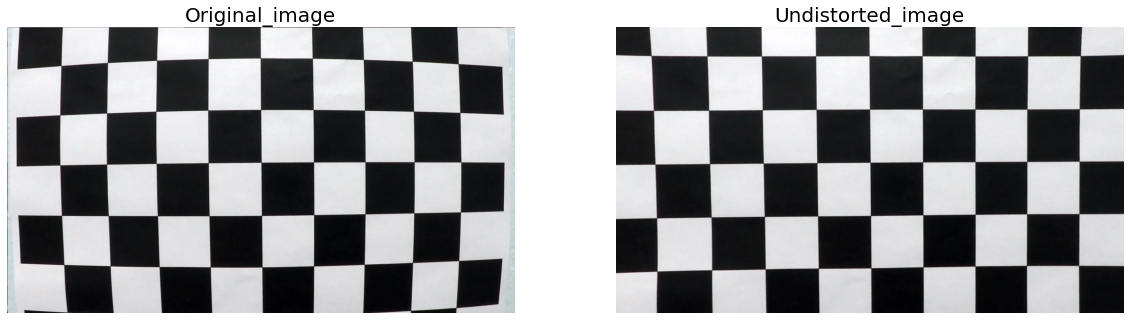

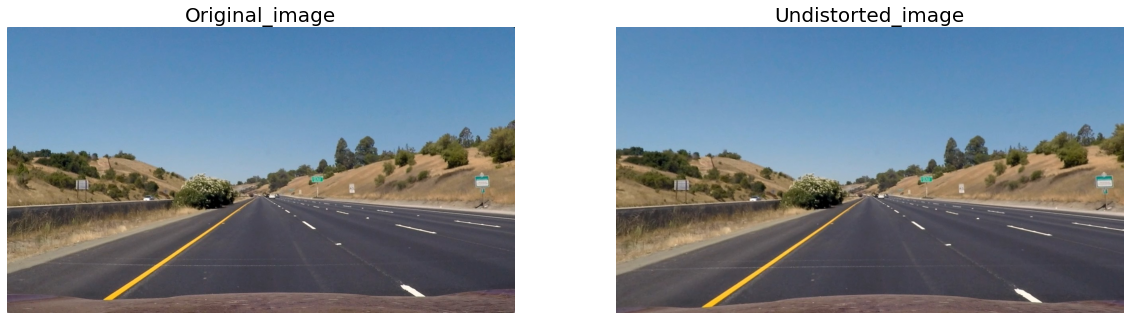

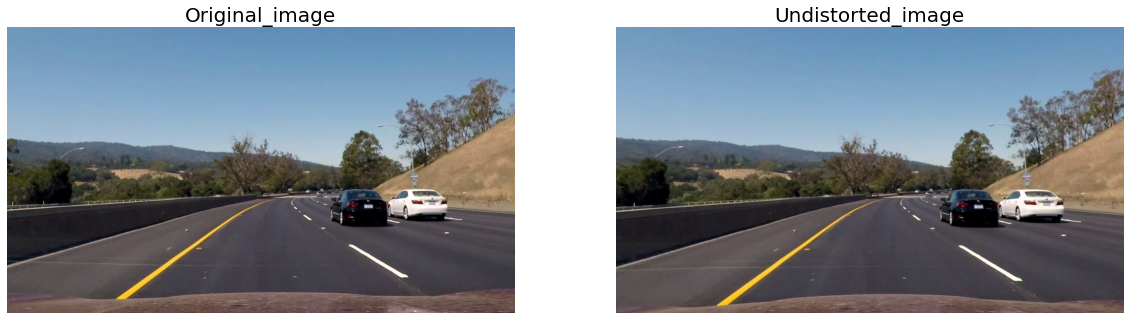

In [4]:
def camera_calibration():
    """
    wrapper function to find the camera calibration coordinates through chess board corners detection
    ideally should be perforemd on the images taken from camera that is going to be used in lane detection 
    
    """
    print('starting camera calibration')
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    obj_pt = np.zeros((6 * 9, 3), np.float32)
    obj_pt[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
    
    chess_images = glob.glob('./camera_cal/*')
    nx = 9    # number of corners in x axis
    ny = 6    # number of corners in y axis
    
    obj_points = []    # 3d points in real world space
    img_points = []    # 2d points in image plane

    for image in chess_images:
        img = cv2.imread(image)
        gray_image  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        det , corners = cv2.findChessboardCorners(gray_image, (nx, ny), None) 
        
        if det :
            img = cv2.drawChessboardCorners(img, (nx, ny), corners, det)
            #cv2.imshow('img',img)
            #cv2.waitKey(0)
            obj_points.append(obj_pt)
            img_points.append(corners)
            
    shape = (img.shape[1], img.shape[0])
    ret, mtx, dist, _ , _ = cv2.calibrateCamera(obj_points, img_points, shape, None, None)
    print('calibration performed')
    #cv2.distroyAllWindows()
    return mtx, dist
    
# calibration needed only once in the beginning and can be loaded in the next run form the saved file
if os.path.exists('camera_calib.p'):
    with open('camera_calib.p', mode='rb') as f:
        data = pickle.load(f)
        mtx, dist = data['mtx'], data['dist']
        print('Loaded camera calibration matrix & distortion coefficients!')
else:
    mtx, dist = camera_calibration()
    with open('camera_calib.p', mode='wb') as f:
        pickle.dump({'mtx': mtx, 'dist': dist}, f)
    
    
def undistort(distorted_image, mtx, dist):
    return cv2.undistort(distorted_image, mtx, dist, None, mtx)

mtx , dist = camera_calibration()
chess_img_path = './camera_cal/calibration1.jpg'
original_img = cv2.imread(chess_img_path)
undistorted_img = undistort(original_img, mtx, dist)
plot_images([
    (original_img, 'Original_image'),
    (undistorted_img, 'Undistorted_image')
])

img_path = './test_images/straight_line_img1.jpg'
test_img1 = mpimg.imread(img_path)
test_undistorted_img1 = undistort(test_img1, mtx, dist)
plot_images([
    (test_img1, 'Original_image'),
    (test_undistorted_img1, 'Undistorted_image')
])

img_path = './test_images/straight_line_img2.jpg'
test_img2 = mpimg.imread(img_path)
test_undistorted_img2 = undistort(test_img2, mtx, dist)
plot_images([
    (test_img2, 'Original_image'),
    (test_undistorted_img2, 'Undistorted_image')
])

# undistorted_cropped_img = region_of_interest(undistorted_img1, vertices, vertices_inner)
# plot_images([
#     (undistorted_cropped_img, 'cropped_undistorted')])

### PERSPECTIVE TRANSFORMATION

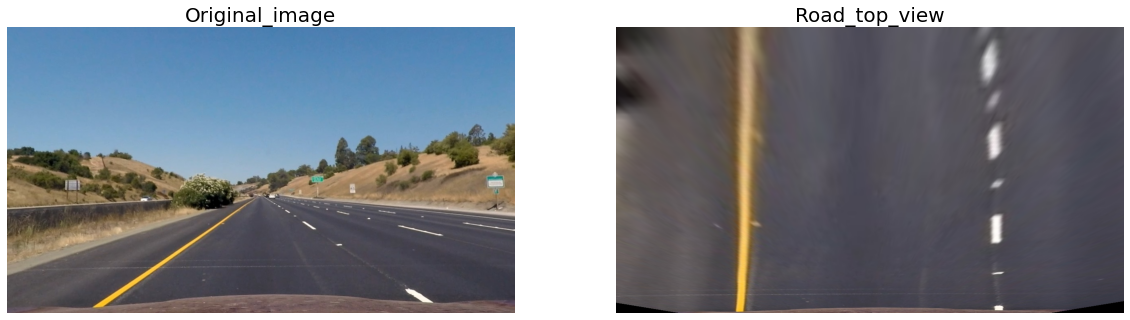

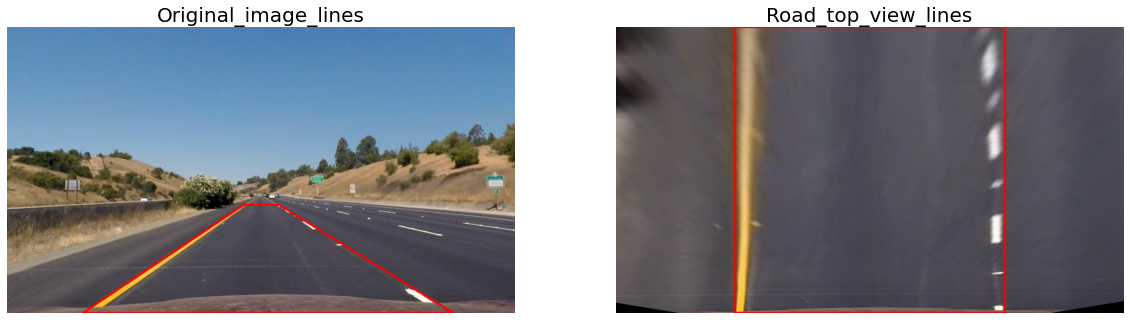

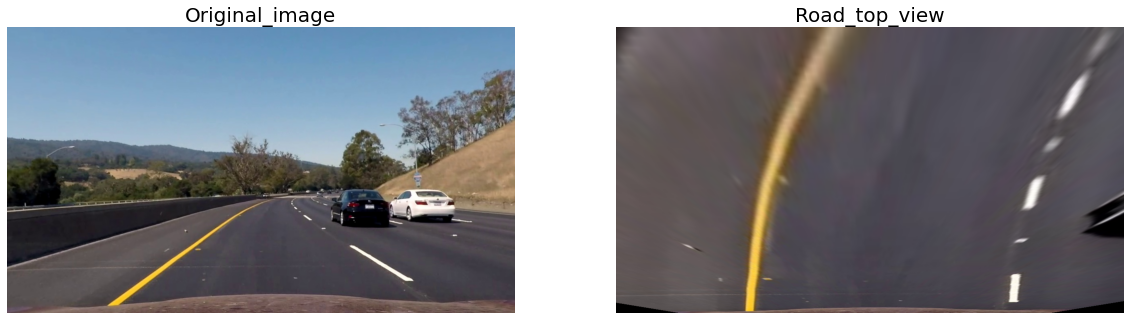

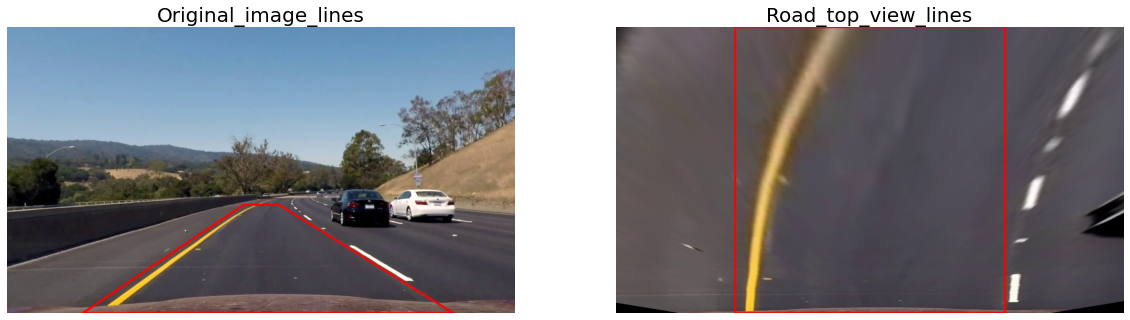

In [8]:
def warp_image(img, mtx, dist, visualization = False):
    '''
    helper function to convert the perspective of the image when looked
    from the front of the car or from bird's eye view
    
    '''
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = undistort(img, mtx, dist)
    original_image = img.copy()
    xsize = img.shape[1]
    ysize = img.shape[0]
    offset = 300

    src_pts = np.float32([
        (596, 447), # Top-left corner
        (190, 720), # Bottom-left corner
        (1125, 720), # Bottom-right corner
        (685, 447) # Top-right corner
    ])

    dst_pts = np.float32([
        [offset, 0], 
        [offset, ysize],
        [xsize - offset, ysize], 
        [xsize - offset, 0]
    ])
    
    # Get the perspective transformation matrix and its inverse
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    invM = cv2.getPerspectiveTransform(dst_pts, src_pts)
    
    # Warp the image
    warped = cv2.warpPerspective(img, M, (xsize, ysize), flags = cv2.INTER_LINEAR)
    
    if visualization:
        img_cpy = img.copy()
        warped_cpy = warped.copy()
        warped_poly = cv2.polylines(img_cpy, np.int32([src_pts]), True, (255,0,0), 3)
        warped2_poly = cv2.polylines(warped_cpy, np.int32([dst_pts]), True, (255,0,0), 3)
        plot_images([
            (img, 'Original_image'),
            (warped, 'Road_top_view')
        ])
        plot_images([
            (warped_poly, 'Original_image_lines'),
            (warped2_poly, 'Road_top_view_lines')
        ])
        
    return warped, original_image, M, invM
# Test image 1        
test_img_path1 = './test_images/straight_line_img1.jpg'
test_img1 = cv2.imread(test_img_path1)
warped_test_img1,_,_,_ = warp_image(test_img1, mtx, dist, visualization = True)

# Test image 2
test_img_path2 = './test_images/straight_line_img2.jpg'
test_img2 = cv2.imread(test_img_path2)
warped_test_img2,_,_,_ = warp_image(test_img2, mtx, dist, visualization = True)


Helper function for image thresholding depending on color gradients

## BINARY THRESHOLDING
 - To generate binary threshold image to filter lane lines with yellow and white color

In [9]:
# Parameters
GRADIENT_THRESH = (20, 100)
S_CHANNEL_THRESH = (80, 255)
L_CHANNEL_THRESH = (80, 255)
B_CHANNEL_THRESH = (150, 200)
L2_CHANNEL_THRESH = (225, 255)

def seperate_hls(rgb_img):
    hls = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    l = hls[:,:,1]
    s = hls[:,:,2]
    return h, l, s

def seperate_lab(rgb_img):
    lab = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2Lab)
    l = lab[:,:,0]
    a = lab[:,:,1]
    b = lab[:,:,2]
    return l, a, b

def seperate_luv(rgb_img):
    luv = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2Luv)
    l = luv[:,:,0]
    u = luv[:,:,1]
    v = luv[:,:,2]
    return l, u, v

def binary_threshold_hls(rgb_img, sthresh, lthresh):
    h, l, s = seperate_hls(rgb_img)
    binary = np.zeros_like(h)
    binary[
        ((s > sthresh[0]) & (s <= sthresh[1])) &
        ((l > lthresh[0]) & (l <= lthresh[1]))
    ] = 1
    return binary

def binary_threshold_lab_luv(rgb_img, bthresh, lthresh):
    l, a, b = seperate_lab(rgb_img)
    l2, u, v = seperate_luv(rgb_img)
    binary = np.zeros_like(l)
    binary[
        ((b > bthresh[0]) & (b <= bthresh[1])) |
        ((l2 > lthresh[0]) & (l2 <= lthresh[1]))
    ] = 1
    return binary

def gradient_threshold(channel, thresh):
    # Take the derivative in x
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0)
    # Absolute x derivative to accentuate lines away from horizontal
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold gradient channel
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary



- Applying the color thresholding on the image to visualize the output

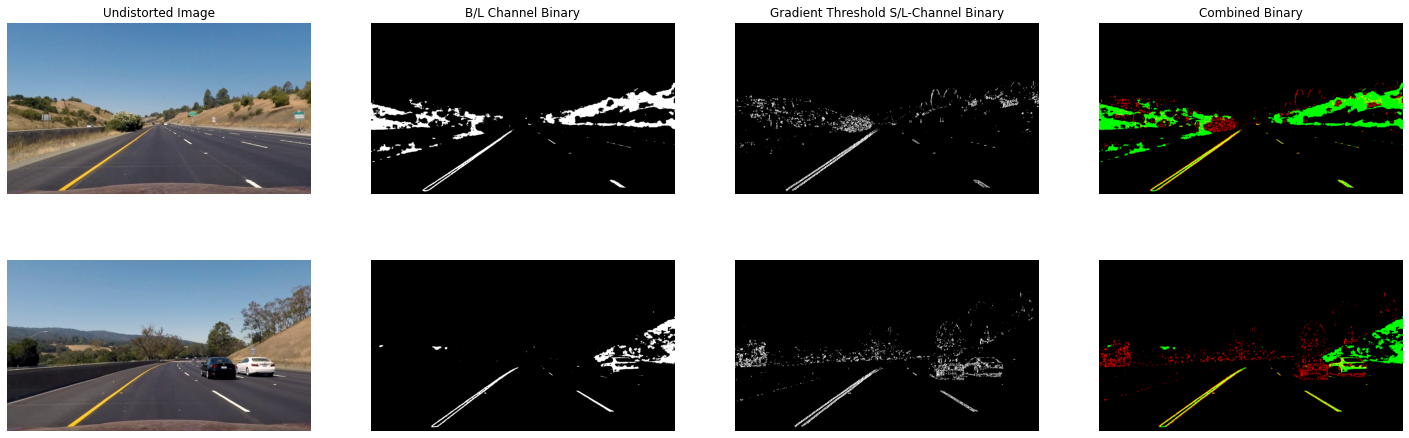

In [10]:
# LAB and LUV channel threshold
s_binary = binary_threshold_lab_luv(test_undistorted_img1, B_CHANNEL_THRESH, L2_CHANNEL_THRESH)
s_binary2 = binary_threshold_lab_luv(test_undistorted_img2, B_CHANNEL_THRESH, L2_CHANNEL_THRESH)

# Gradient threshold on S channel
h, l, s = seperate_hls(test_undistorted_img1)
sxbinary = gradient_threshold(s, GRADIENT_THRESH)

h2, l2, s2 = seperate_hls(test_undistorted_img2)
sxbinary2 = gradient_threshold(s2, GRADIENT_THRESH)

# Combine two binary images to view their contribution in green and red
color_binary = np.dstack((sxbinary, s_binary, np.zeros_like(sxbinary))) * 255
color_binary2 = np.dstack((sxbinary2, s_binary2, np.zeros_like(sxbinary2))) * 255

# Draw figure for binary images
f, axarr = plt.subplots(2,4)
f.set_size_inches(25, 8)
axarr[0,0].imshow(test_undistorted_img1)
axarr[0,1].imshow(s_binary, cmap='gray')
axarr[0,2].imshow(sxbinary, cmap='gray')
axarr[0,3].imshow(color_binary)
axarr[0,0].set_title("Undistorted Image")
axarr[0,1].set_title("B/L Channel Binary")
axarr[0,2].set_title("Gradient Threshold S/L-Channel Binary")
axarr[0,3].set_title("Combined Binary")
axarr[0,0].axis('off')
axarr[0,1].axis('off')
axarr[0,2].axis('off')
axarr[0,3].axis('off')
axarr[1, 0].imshow(test_undistorted_img2)
axarr[1, 1].imshow(s_binary2, cmap='gray')
axarr[1, 2].imshow(sxbinary2, cmap='gray')
axarr[1, 3].imshow(color_binary2)
axarr[1, 0].axis('off')
axarr[1, 1].axis('off')
axarr[1, 2].axis('off')
axarr[1, 3].axis('off');

- Finding the arrival of the lane in the image by plotting the histogram of the filtered image. The peaks indicates the lane presence.

In [11]:
def histo_peak(histo):
    """Find left and right peaks of histogram"""
    midpoint = np.int64(histo.shape[0]/2)
    leftx_base = np.argmax(histo[:midpoint])
    rightx_base = np.argmax(histo[midpoint:]) + midpoint
    return leftx_base, rightx_base

def get_lane_indices_sliding_windows(binary_warped, leftx_base, rightx_base, n_windows, margin, recenter_minpix):
    """Get lane line pixel indices by using sliding window technique"""
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = out_img.copy()
    # Set height of windows
    window_height = np.int64(binary_warped.shape[0]/n_windows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    for window in range(n_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > recenter_minpix:
            leftx_current = np.int64(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > recenter_minpix:        
            rightx_current = np.int64(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    return left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img

def get_lane_indices_from_prev_window(binary_warped_img, left_fit, right_fit, margin):
    """Detect lane line by searching around detection of previous sliding window detection"""
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_lane_inds, right_lane_inds, ploty, left_fitx, right_fitx

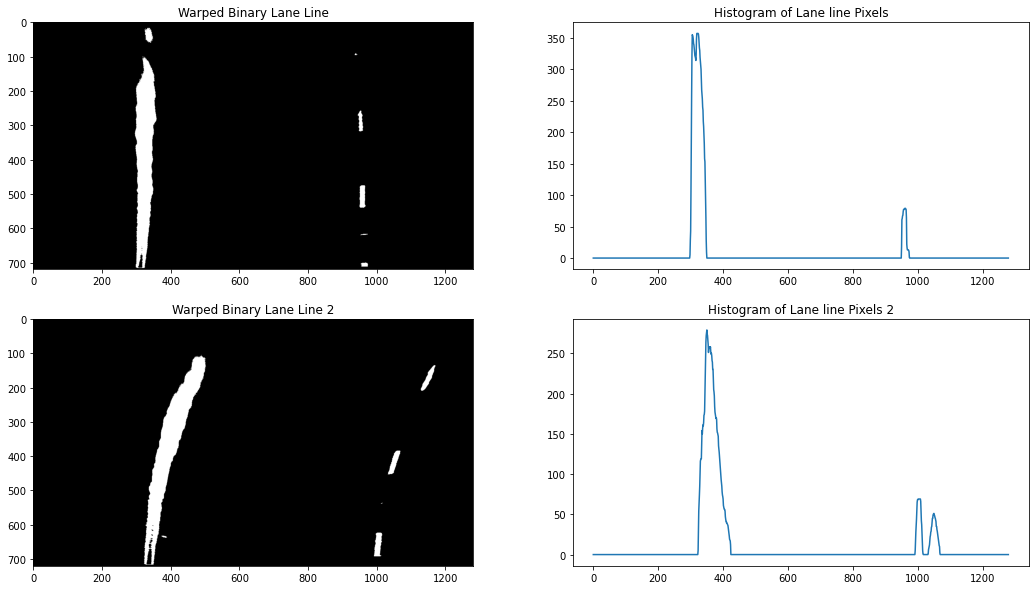

In [12]:
# Warp binary image of lane line
#warped_test_img, _, _, _ = warp_image(test_img_path, mtx, dist, visualization = False)
binary_warped = binary_threshold_lab_luv(warped_test_img1, B_CHANNEL_THRESH, L2_CHANNEL_THRESH)
binary_warped2 = binary_threshold_lab_luv(warped_test_img2, B_CHANNEL_THRESH, L2_CHANNEL_THRESH)

# Calculate histogram of lane line pixels
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
histogram2 = np.sum(binary_warped2[int(binary_warped2.shape[0]/2):,:], axis=0)

# Draw figure for warped binary and histogram
f, axarr = plt.subplots(2,2)
f.set_size_inches(18, 10)
axarr[0, 0].imshow(binary_warped, cmap='gray')
axarr[0, 1].plot(histogram)
axarr[0, 0].set_title("Warped Binary Lane Line")
axarr[0, 1].set_title("Histogram of Lane line Pixels")
axarr[1, 0].imshow(binary_warped2, cmap='gray')
axarr[1, 1].plot(histogram2)
axarr[1, 0].set_title("Warped Binary Lane Line 2")
axarr[1, 1].set_title("Histogram of Lane line Pixels 2");

### SLIDING WINDOW TECHNIQUE
- to find the lane llne continuity throughout the frame and fit the polynomial line to define curvature

#### Parameters

In [13]:
N_WINDOWS = 10
MARGIN = 100
RECENTER_MINPIX = 50

# Define conversions in x and y from pixels space to meters
YM_PER_PIX = 30 / 720 # meters per pixel in y dimension
XM_PER_PIX = 3.7 / 700 # meters per pixel in x dimension

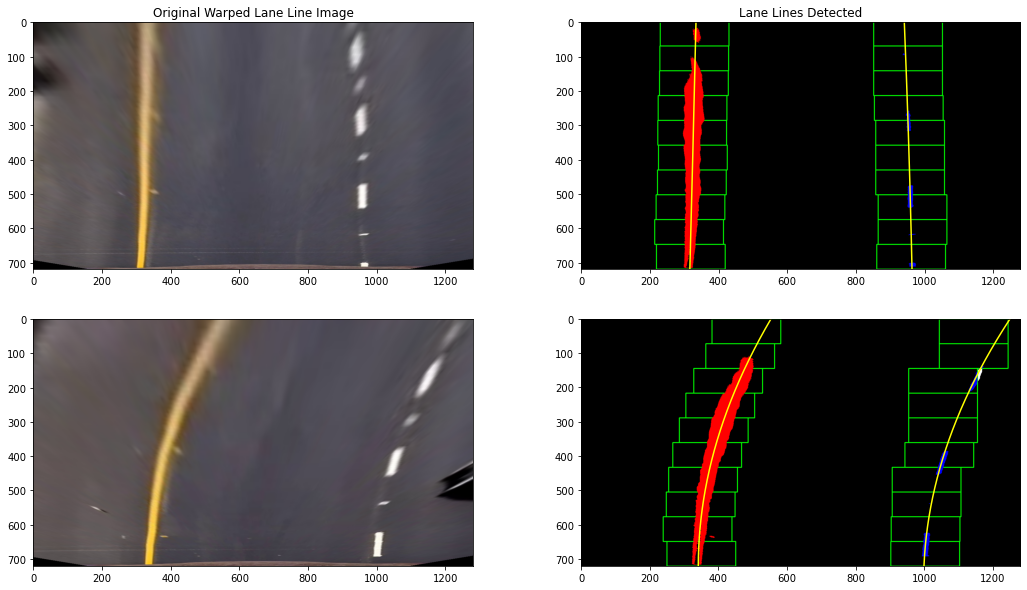

In [14]:
leftx_base, rightx_base = histo_peak(histogram)
left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img = get_lane_indices_sliding_windows(
    binary_warped, leftx_base, rightx_base, N_WINDOWS, MARGIN, RECENTER_MINPIX)

leftx_base2, rightx_base2 = histo_peak(histogram2)
left_lane_inds2, right_lane_inds2, nonzerox2, nonzeroy2, out_img2 = get_lane_indices_sliding_windows(
    binary_warped2, leftx_base2, rightx_base2, N_WINDOWS, MARGIN, RECENTER_MINPIX)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

leftx2 = nonzerox2[left_lane_inds2]
lefty2 = nonzeroy2[left_lane_inds2] 
rightx2 = nonzerox2[right_lane_inds2]
righty2 = nonzeroy2[right_lane_inds2] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
left_fit2 = np.polyfit(lefty2, leftx2, 2)
right_fit2 = np.polyfit(righty2, rightx2, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

ploty2 = np.linspace(0, binary_warped2.shape[0]-1, binary_warped2.shape[0] )
left_fitx2 = left_fit2[0]*ploty2**2 + left_fit2[1]*ploty2 + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty2**2 + right_fit2[1]*ploty2 + right_fit2[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
out_img2[nonzeroy2[left_lane_inds2], nonzerox2[left_lane_inds2]] = [255, 0, 0]
out_img2[nonzeroy2[right_lane_inds2], nonzerox2[right_lane_inds2]] = [0, 0, 255]

# Draw figures of line lanes detected
f, axarr = plt.subplots(2,2)
f.set_size_inches(18, 10)
axarr[0, 0].imshow(warped_test_img1)
axarr[0, 1].imshow(out_img)
axarr[0, 1].plot(left_fitx, ploty, color='yellow')
axarr[0, 1].plot(right_fitx, ploty, color='yellow')
axarr[0, 0].set_title("Original Warped Lane Line Image")
axarr[0, 1].set_title("Lane Lines Detected");
axarr[1, 0].imshow(warped_test_img2)
axarr[1, 1].plot(left_fitx2, ploty2, color='yellow')
axarr[1, 1].plot(right_fitx2, ploty2, color='yellow')
axarr[1, 1].imshow(out_img2)
plt.xlim(0, 1280)
plt.ylim(720, 0);

#### Searching the lanes from previos windows to find line continuity after using the sliding window method

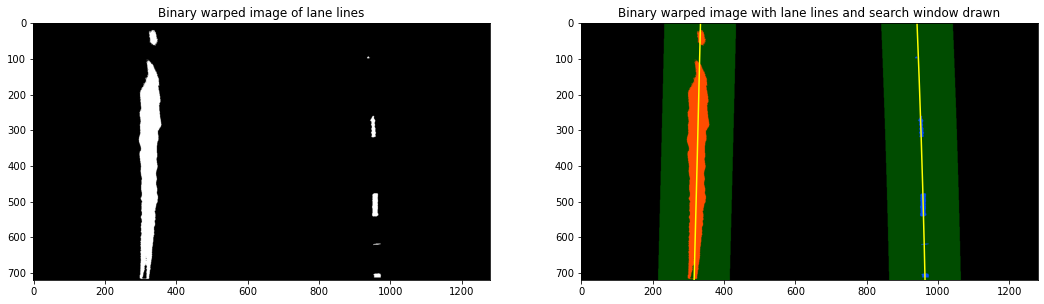

In [15]:
left_lane_inds, right_lane_inds, ploty, left_fitx, right_fitx = get_lane_indices_from_prev_window(
    binary_warped, left_fit, right_fit, MARGIN)

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-MARGIN, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+MARGIN, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-MARGIN, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+MARGIN, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

# Plot the figure
f, axarr = plt.subplots(1,2)
f.set_size_inches(18, 5)
axarr[0].imshow(binary_warped, cmap='gray')
axarr[1].imshow(result)
axarr[1].plot(left_fitx, ploty, color='yellow')
axarr[1].plot(right_fitx, ploty, color='yellow')
axarr[0].set_title("Binary warped image of lane lines")
axarr[1].set_title("Binary warped image with lane lines and search window drawn");

### Projecting the detected lanes onto original image

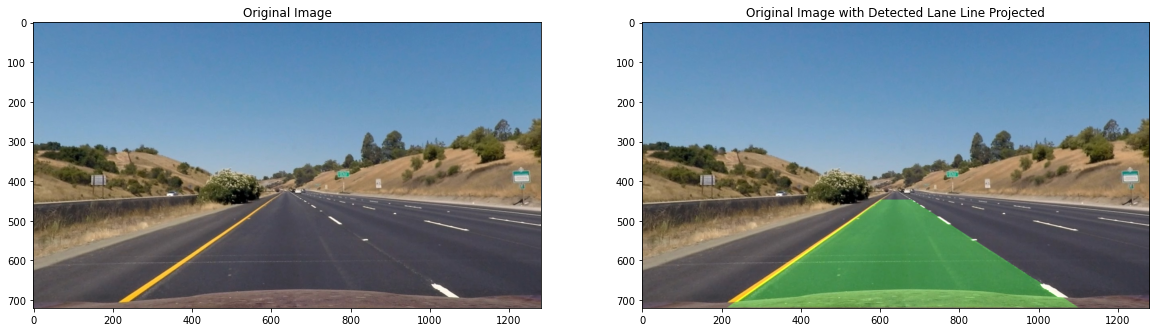

In [16]:
# lane_test_img = cv2.imread( './test_images/straight_line_img2.jpg')
# lane_test_img_rgb = cv2.cvtColor(lane_test_img , cv2.COLOR_BGR2RGB)

_, lane_test_img_rgb , M, M_INV = warp_image(test_img1, mtx, dist, visualization = False)

def project_lane_line(original_image, binary_warped, ploty, left_fitx, right_fitx, m_inv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, m_inv, (original_image.shape[1], original_image.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    return result


result = project_lane_line(lane_test_img_rgb, binary_warped, ploty, left_fitx, right_fitx, M_INV)

# Plot original image and original image with lane line projected
f, axarr = plt.subplots(1,2)
f.set_size_inches(20, 8)
axarr[0].imshow(lane_test_img_rgb, cmap='gray')
axarr[1].imshow(result)
axarr[0].set_title("Original Image")
axarr[1].set_title("Original Image with Detected Lane Line Projected");

### Radius of curvature of lanes and vehicle off-center calculation

In [17]:
def calc_curvature(ploty, leftx, rightx, lefty, righty, unit="m"):
    """returns curvature in meters."""
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*YM_PER_PIX, leftx*XM_PER_PIX, 2)
    right_fit_cr = np.polyfit(righty*YM_PER_PIX, rightx*XM_PER_PIX, 2)
    # Calculate the new radii of curvature
    left_curvem = ((1 + (2*left_fit_cr[0]*y_eval*YM_PER_PIX + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curvem = ((1 + (2*right_fit_cr[0]*y_eval*YM_PER_PIX + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curvem, right_curvem

def calc_car_pos(img, left_fit, right_fit):
    # Assuming camera is centered in the image, return position of car in cms.
    car_loc = img.shape[1] / 2

    # Find lane line bottom x-corrdinate
    height = img.shape[0]
    bottom_left = left_fit[0]*height**2 + left_fit[1]*height + left_fit[2]
    bottom_right = right_fit[0]*height**2 + right_fit[1]*height + right_fit[2]

    center_lane = (bottom_right - bottom_left)/2 + bottom_left 
    center_offset = ( np.abs(car_loc) - np.abs(center_lane)) * XM_PER_PIX * 100
    return center_offset

404.0553662538321 m 385.3245003842008 m
72868.8263391313 m 12367.11475593762 m
0.08670491438463485cm


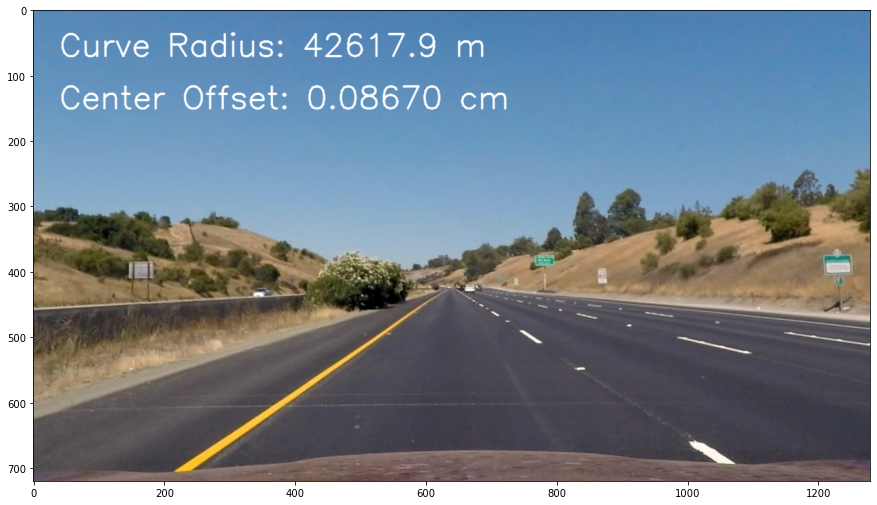

In [18]:
# radius of curvature for straight lane lines
left_curvem, right_curvem = calc_curvature(ploty2, leftx2, rightx2, lefty2, righty2)
print(left_curvem, 'm', right_curvem, 'm')

# Radius of curvature for curving road lane lines
left_curvem, right_curvem = calc_curvature(ploty, leftx, rightx, lefty, righty)
print(left_curvem, 'm', right_curvem, 'm')

# Vehicle position off-center to lane middle assuign a 3.7m wide lane
center_offset = calc_car_pos(lane_test_img_rgb, left_fit, right_fit)
print(str(center_offset) + 'cm')

img_cp = lane_test_img_rgb.copy()
cv2.putText(img_cp,'Curve Radius: '+str((left_curvem+right_curvem)/2)[:7]+' m',(40,70), cv2.FONT_HERSHEY_SIMPLEX, 1.6,(255,255,255),2,cv2.LINE_AA)
cv2.putText(img_cp,'Center Offset: '+str(center_offset)[:7]+' cm',(40,150), cv2.FONT_HERSHEY_SIMPLEX, 1.6,(255,255,255),2,cv2.LINE_AA)
plt.figure(figsize = (15, 15))
plt.imshow(img_cp)

## Video Pipeline

In [19]:
# Parameters
VID_INPUT = "project_video.mp4"
VID_OUT_DIR = ".\\video_results"
VID_OUTPUT_PATH = VID_OUT_DIR + "\\project_video_result.mp4"
IMG_SIZE = test_undistorted_img1.shape[::-1][1:]
CO_THRES = 5
PIXEL_THRES = 600


# Global Parameters
global_vars = {
    'left_fit': None,
    'right_fit': None,
    'left_fitx': None,
    'right_fitx': None,
    'co': 0
}

### Pipeline Function


In [20]:
def run_pipeline(image):
    # Preprocess Image
    # image_undist = cv2.undistort(image, MTX, DIST, None, MTX)
    image_undist = undistort(image, mtx, dist)
    s_binary = binary_threshold_lab_luv(image_undist, B_CHANNEL_THRESH, L2_CHANNEL_THRESH)
    binary_warped = cv2.warpPerspective(s_binary, M, IMG_SIZE, flags=cv2.INTER_LINEAR)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    # Identify Lane Lines using sliding window
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    leftx_base, rightx_base = histo_peak(histogram)
    left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img = get_lane_indices_sliding_windows(
        binary_warped, leftx_base, rightx_base, N_WINDOWS, MARGIN, RECENTER_MINPIX
    )
    if len(right_lane_inds) < PIXEL_THRES:
        result = project_lane_line(
            image_undist, binary_warped, ploty, global_vars['left_fitx'], global_vars['right_fitx'], M_INV
        )
    else:
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        co = calc_car_pos(image, left_fit, right_fit)
        left_curvem, right_curvem = calc_curvature(ploty, leftx, rightx, lefty, righty)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        left_curvem, right_curvem = calc_curvature(ploty, leftx, rightx, lefty, righty)
        result = project_lane_line(image_undist, binary_warped, ploty, left_fitx, right_fitx, M_INV)
        global_vars['left_fitx'] = left_fitx
        global_vars['right_fitx'] = right_fitx
        global_vars['left_curvem'] = left_curvem
        global_vars['right_curvem'] = right_curvem
        global_vars['co'] = co

    cv2.putText(result,'Curve Radius: '+str((global_vars['left_curvem']+global_vars['right_curvem'])/2)[:7]+' m',(660,70), cv2.FONT_HERSHEY_COMPLEX, 1.3,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Center Offset: '+str(global_vars['co'])[:7]+' cm',(660,130), cv2.FONT_HERSHEY_COMPLEX, 1.3,(255,255,255),2,cv2.LINE_AA)
    return result

### If main:

In [21]:
from moviepy.editor import VideoFileClip

if not os.path.exists(VID_OUT_DIR):
    os.makedirs(VID_OUT_DIR)

# Process each frame in the project video input and output a new video with lane lines projected
clip = VideoFileClip(VID_INPUT)
new_clip = clip.fl_image(run_pipeline)
new_clip.write_videofile(VID_OUTPUT_PATH, audio=False, verbose=False);

Moviepy - Building video .\video_results\project_video_result.mp4.
Moviepy - Writing video .\video_results\project_video_result.mp4



Moviepy - Done !
Moviepy - video ready .\video_results\project_video_result.mp4
